# Multi-class Classification and Neural Networks
For this exercise, we use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. 
In the first part of the exercise, we extend the previous implemention of 
logistic regression and apply it to one-vs-all classification.

## Datasets
You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits.  After loading, matrices of the correct dimensions and values will appear in your program’s memory.

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of a digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $ X $. This gives us a $ 5000 \times 400 $ matrix $ X $ where every row is a training example for a handwritten digit image.

$$
X = \begin{bmatrix}
-(x^{(1)})^T- \\
-(x^{(2)})^T- \\
\vdots \\
-(x^{(m)})^T-
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector $ y $ that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

plt.style.use('ggplot')

In [2]:
data1 = scipy.io.loadmat('ex3data1.mat')
X1 = data1['X']
y1 = data1['y']
X1.shape, y1.shape

((5000, 400), (5000, 1))

## Visualizing the data
You will begin by visualizing a subset of the training set. We randomly 
select 100 rows from X and passes those rows
to the displayData function. This function maps each row to a 20 pixel by
20 pixel grayscale image and displays the images together. 

(-0.5, 19.5, 19.5, -0.5)

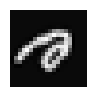

In [17]:
plt.figure(figsize=(1, 1))
plt.imshow(X1[3000].reshape(20, 20), cmap='gray')
plt.axis('off')

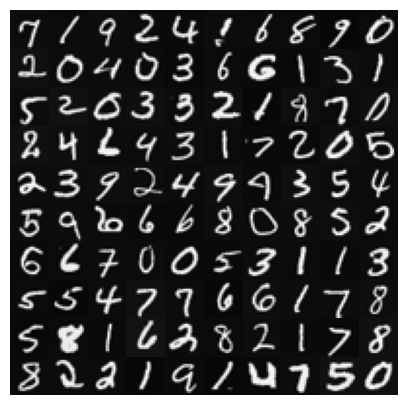

array([[ 7,  1,  9,  2,  4,  1,  6,  8,  9, 10],
       [ 2, 10,  4, 10,  3,  6,  6,  1,  3,  1],
       [ 5,  2, 10,  3,  3,  2,  1,  8,  7, 10],
       [ 2,  4,  6,  4,  3,  1,  7,  2, 10,  5],
       [ 2,  3,  9,  2,  4,  9,  4,  3,  5,  4],
       [ 5,  9,  6,  6,  6,  8, 10,  8,  5,  2],
       [ 6,  6,  7, 10, 10,  5,  3,  1,  1,  3],
       [ 5,  5,  4,  7,  7,  6,  6,  1,  7,  8],
       [ 5,  8,  1,  6,  2,  8,  2,  1,  7,  8],
       [ 8,  2,  2,  1,  9,  1,  4,  7,  5, 10]], dtype=uint8)

In [38]:
def displayData(X, y, size=10):
    indices = np.random.choice(len(X), size*size, replace=False)
    labels = y[indices]
    selected_images = X[indices]
    fig, axes = plt.subplots(size, size, figsize=(5, 5)) 
    
    for i, ax in enumerate(axes.flat):
        rotated_image = np.rot90(np.fliplr((selected_images[i].reshape(20, 20))))
        ax.imshow(rotated_image.reshape(20, 20), cmap='gray')
        ax.axis('off')  # Hide the axes
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove spaces between plots
    plt.show()
    return labels.reshape(size, size)
displayData(X1, y1)